# Main Quest 03 - CNN

---
## 학습목표
- MNIST Dataset와 텐서플로우 Sequential API를 이용하여 숫자 손글씨 인식기를 만들어 볼 수 있다.
- Sequential Model을 활용하여 딥러닝 네트워크를 설계하고 학습 시킬 수 있다.
- 테스트 데이터로 성능을 확인하고 하이퍼파라미터 조정을 시도하여 성능을 높여볼 수 있다.
- 가위바위보 분류기를 만들기 위한 기본 데이터를 웹캠으로 제작 할 수 있다.

## 학습 내용
- 이미 잘 정제된 10개 클래스의 숫자 손글씨 데이터를 분류하는 classifier 만들기
- 정제되지 않은 웹캠 사진으로부터 데이터 만들어보기
- 흑백 사진이 아닌 컬러 사진을 학습하는 classifier 만들기
- 분류하고자 하는 클래스의 개수를 마음대로 조절하기 (10개에서 3개로)

## 1. 텐서플로우 Sequential API를 활용한 <MNIST 손글씨 인식기>
- 데이터셋 관련 정보 링크 : [텐서플로우](https://www.tensorflow.org/datasets/catalog/mnist?hl=ko)


In [1]:
## 데이터 불러오기
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os


print(tf.__version__)   # Tensorflow의 버전을 출력

mnist = keras.datasets.mnist

# MNIST 데이터를 로드. 다운로드하지 않았다면 다운로드까지 자동으로 진행됩니다. 
(x_train, y_train), (x_test, y_test) = mnist.load_data()   

print(len(x_train))  # x_train 배열의 크기를 출력

2.6.0
11501568/11490434 [==============================] - 0s 0us/step
60000


In [2]:
x_train.shape

(60000, 28, 28)

In [3]:
len(x_test)

10000

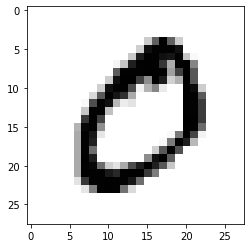

In [4]:
# 손글씨 이미지 출력
plt.imshow(x_train[1],cmap=plt.cm.binary)
plt.show()

In [5]:
# 위 정답레이블
print(y_train[1])

0


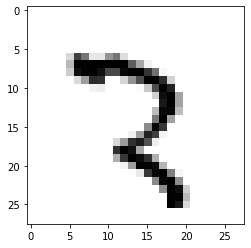

501 번째 이미지의 숫자는 바로  3 입니다.


In [6]:
# 또다른 이미지 출력 : index에 0에서 59999 사이 숫자를 지정해 보세요.
index=500     
plt.imshow(x_train[index],cmap=plt.cm.binary)
plt.show()
print( (index+1), '번째 이미지의 숫자는 바로 ',  y_train[index], '입니다.')

- [matplotlib 추가 자료 링크](https://matplotlib.org/cheatsheets/)

### 데이터 전처리
- 입력 데이터 픽셀값 정규화
    - 0\~255 값을 0\~1 사이의 값으로 변환

In [7]:
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0
print('최소값:',np.min(x_train_norm), ' 최대값:',np.max(x_train_norm))

최소값: 0.0  최대값: 1.0


### Sequential model
- tensorflow keras

In [8]:
# tf.keras Sequential - LeNet CNN
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


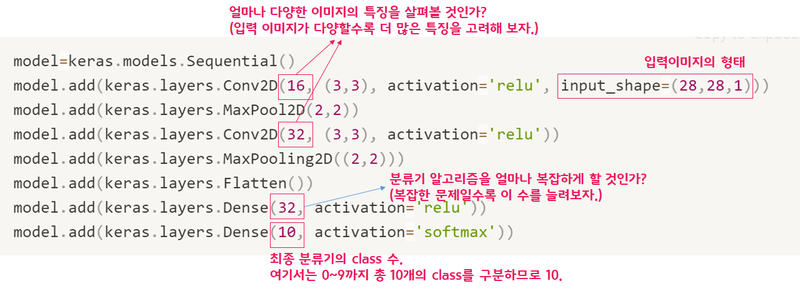
- convolutiona layer(hidden layer) activation function : ReLU
- print activation function : softmax
- Conv2D 레이어의 첫 번째 인자 : 사용하는 이미지 특징의 수
    - 먼저 16개의 이미지 특징파악, 그 뒤에 32개의 이미지 특징 파악
    - 만약 복잡한 특징을 가진 이미지라면 이 숫자를 늘려주는게 좋음
- Dense 레이어의 첫 번째 인자 : 분류기에 사용되는 뉴런의 숫자 
    - 이 값이 클수록 보다 복잡한 분류기를 만들 수 있다
    - 10개의 숫자가 아닌 알파벳을 구분하고 싶다면 : 대문자 26개, 소문자 26개 = 총 52개의 클래스 => 64, 128 로 설정
- 마지막 Dense 레이어의 뉴런 숫자 : 결과적으로 분류해 내야 하는 클래스 수
    - 숫자 인식기 : 10
    - 알파벳 인식기 : 52

In [9]:
# model 정보 확인
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

### CNN 학습시키기
- 입력데이터 : (데이터갯수, 이미지 크기 x, 이미지 크기 y, 채널수) 

In [10]:
# 채널정보가 포함되어있지 않음
print(f"Before Reshape - x_train_norm shape: {x_train_norm.shape}")
print(f"Before Reshape - x_test_norm shape: {x_test_norm.shape}")

# 채널정보 추가
x_train_reshaped=x_train_norm.reshape( -1, 28, 28, 1)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.
x_test_reshaped=x_test_norm.reshape( -1, 28, 28, 1)

print(f"After Reshape - x_train_reshaped shape: {x_train_reshaped.shape}")
print(f"After Reshape - x_test_reshaped shape: {x_test_reshaped.shape}")

Before Reshape - x_train_norm shape: (60000, 28, 28)
Before Reshape - x_test_norm shape: (10000, 28, 28)
After Reshape - x_train_reshaped shape: (60000, 28, 28, 1)
After Reshape - x_test_reshaped shape: (10000, 28, 28, 1)


In [11]:
# 딥러닝 네트워크 학습
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 에포크 : 10 -> 전체 60,000개 데이터 10번 반복해서 학습
model.fit(x_train_reshaped, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 56s 29ms/step - loss: 0.1743 - accuracy: 0.9463
Epoch 2/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0592 - accuracy: 0.9815
Epoch 3/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0434 - accuracy: 0.9860
Epoch 4/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0334 - accuracy: 0.9893
Epoch 5/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0267 - accuracy: 0.9919
Epoch 6/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0219 - accuracy: 0.9930
Epoch 7/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0185 - accuracy: 0.9941
Epoch 8/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0151 - accuracy: 0.9951
Epoch 9/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0128 - accuracy: 0.9958
Epoch 10/10
1875/1875 [==============================] - 70s 37m

In [12]:
# 테스트 데이터로 성능 확인
test_loss, test_accuracy = model.evaluate(x_test_reshaped,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

313/313 - 2s - loss: 0.0396 - accuracy: 0.9891
test_loss: 0.039618443697690964
test_accuracy: 0.9890999794006348


- 훈련 정확도가 99%로 높아서 테스트 정확도도 높게 나올줄 알았는데, 테스트 정확도는 보다 작은 98%가 나왔다
    - 노드 설명에 따르면 학습할때마다 test_loss, test_accuracy도 변동된다고 한다
    
[추측원인]
- 위 MNIST 데이터셋 참고문헌을 보면 학습용 데이터와 시험용 데이터의 손글씨 주인이 다르다고 함
    - 한 번도 본 적이 없는 필체의 손글씨가 섞여 있을 가능성이 있고, 때문에 학습한 데이터와는 완전 다른 새로운 데이터값에 대해서는 예측이 안되는것

---
### model.predict() 로 입력값을 보고 실제로 추론한 확률 분포 확인

In [13]:
predicted_result = model.predict(x_test_reshaped)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [7.42208812e-13 8.47506527e-12 1.59060317e-11 3.22845093e-12
 5.02630740e-14 3.32400042e-13 1.20164374e-20 1.00000000e+00
 2.25545494e-13 1.81115845e-09]
model이 추론한 가장 가능성이 높은 결과 :  7
실제 데이터의 라벨 :  7


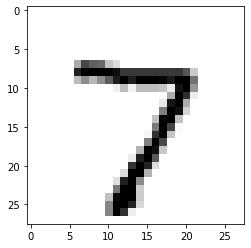

In [14]:
# 실제 정답과 확인
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

예측확률분포: [1.6220798e-10 9.9907458e-01 2.3549157e-05 1.7606243e-09 8.9662132e-04
 9.2694008e-10 5.0697668e-06 3.1894061e-08 1.2679790e-07 1.5686304e-10]
라벨: 6, 예측결과: 1


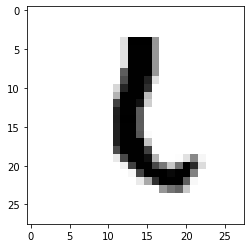

예측확률분포: [1.12336815e-08 3.47785540e-02 5.84224379e-03 1.45284869e-02
 1.50821870e-06 5.17045873e-09 4.53812498e-13 9.44835126e-01
 1.97759775e-07 1.40180018e-05]
라벨: 2, 예측결과: 7


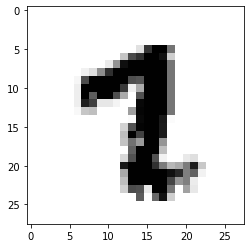

예측확률분포: [4.8905565e-15 4.0211004e-10 2.2513805e-02 5.6770983e-05 3.2645173e-12
 2.7880836e-13 1.6745340e-18 9.7738588e-01 4.3576958e-05 3.9237957e-10]
라벨: 2, 예측결과: 7


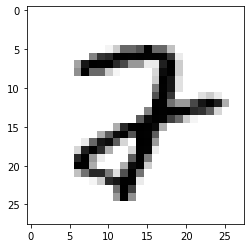

예측확률분포: [1.6566415e-10 2.6380351e-11 4.0611299e-11 4.7330041e-03 6.4555569e-11
 2.4421842e-01 9.5080042e-13 5.1230565e-08 6.7962259e-03 7.4425220e-01]
라벨: 5, 예측결과: 9


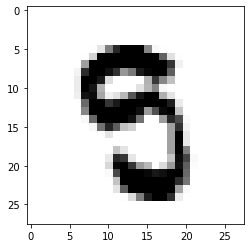

예측확률분포: [2.3778199e-07 5.0475222e-01 4.4113021e-05 2.9727557e-06 1.2140633e-02
 9.0997027e-08 7.7857110e-10 1.4481280e-03 8.9616980e-05 4.8152196e-01]
라벨: 9, 예측결과: 1


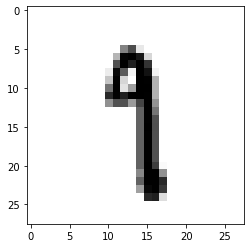

In [15]:
# 정답과 다른 예측을 하는 경우 확인
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

- 이 데이터들은 사람이 봐도 제대로 분류하기 어려운 데이터들이다

### 하이퍼파라미터를 이용해서 성능개선
#### test 1
- n_channel_1=16
- n_channel_2=32
- n_dense=32
- n_train_epoch=10

In [16]:
# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

- 정확도가 98%가 나온다! (내 로컬 컴퓨터로 학습하는것과 차이가 있다..?!)
- 두번째 테스트를 해본다
---
#### test2
- n_channel_1=32
- n_channel_2=64
- n_dense=64
- n_train_epoch=10

In [18]:
# 하이퍼파라미터 변경
n_channel_1=32
n_channel_2=64
n_dense=64
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_reshaped, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                102464    
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

- 아 98%를 넘는게 어렵나보다..! 에포크를 늘린것과 늘리기 전 정확도가 같은걸 보면 큰 영향이 없다
- 학습속도를 위해 에포크 10일때의 값으로 저장해두고, 2번 퀘스트 문제를 다 풀고 시간이 남으면 추가 작업을 해봐야겠다

---
[최적 하이퍼파라미터, 테스트 데이터 정확도]
- test 1
    - n_channel_1=16
    - n_channel_2=32
    - n_dense=32
    - n_train_epoch=10
    - test accuracy : 0.989799976348877